In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import os

# Configure TensorFlow to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

df = pd.read_csv(r"C:\Users\abdel\Downloads\before.csv")

In [7]:
print(df.columns)
for i in range(0, 30844):
    if pd.isnull(df.iloc[i, 0]):
        df.iloc[i, 0] = df.iloc[i, 1]
    elif pd.isnull(df.iloc[i, 1]):
        df.iloc[i, 1] = df.iloc[i, 2]

print(df.isna().sum())
print(df.head())

Index(['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')
Sentence          0
Label             0
Unnamed: 2    30581
Unnamed: 3    30874
dtype: int64
                                            Sentence Label Unnamed: 2  \
0                  " or pg_sleep  (  __TIME__  )  --     1        NaN   
1  create user name identified by pass123 tempora...     1          1   
2   AND 1  =  utl_inaddr.get_host_address   (    ...     1        NaN   
3   select * from users where id  =  '1' or @ @1 ...     1        NaN   
4   select * from users where id  =  1 or 1#"  ( ...     1        NaN   

   Unnamed: 3  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN  


In [8]:
# Data Cleaning
df['Label'] = df['Label'].astype(str)
df = df[~df['Label'].str.contains('[a-zA-Z]')]
df['Label'] = pd.to_numeric(df['Label'], errors='coerce', downcast='integer')
df['Label'] = df['Label'].astype('float32')
df = df.dropna(subset=['Sentence', 'Label'])

In [9]:

# Tokenization and Padding
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Sentence'])
sequences = tokenizer.texts_to_sequences(df['Sentence'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# RNN Model
embedding_dim = 50  # Increased embedding dimension
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(256, return_sequences=True)),  # Increased LSTM units
    Dropout(0.3),
    Bidirectional(LSTM(256)),
    Dense(128, activation='relu'),  
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:




# K-fold Cross-Validation
k_folds =10  
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Initialize variables to store metrics
all_tp, all_fp, all_tn, all_fn = 0, 0, 0, 0
overall_accuracy = 0.0  # Initialize overall accuracy variable

for fold, (train_index, test_index) in enumerate(skf.split(padded_sequences, df['Label'])):
    print(f"\nTraining Fold {fold + 1}")
    
    train_padded = padded_sequences[train_index]
    test_padded = padded_sequences[test_index]
    
    labels_train = df['Label'].iloc[train_index]
    labels_test = df['Label'].iloc[test_index]

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    
    # Training
    model.fit(train_padded, labels_train, epochs=10, validation_data=(test_padded, labels_test), callbacks=[early_stopping])

    # Evaluate
    test_loss, test_accuracy = model.evaluate(test_padded, labels_test)
    overall_accuracy += test_accuracy  # Accumulate accuracy for each fold
    print(f'Test Accuracy (Fold {fold + 1}): {test_accuracy * 100:.2f}%')

    # Confusion Matrix and Metrics
    predictions = (model.predict(test_padded) > 0.5).astype("int32")
    cm = confusion_matrix(labels_test, predictions)

    tp, fp, fn, tn = cm.ravel()
    all_tp += tp
    all_fp += fp
    all_tn += tn
    all_fn += fn

# Calculate and print overall accuracy
overall_accuracy /= k_folds
print(f'\nOverall Accuracy Across all Folds: {overall_accuracy * 100:.2f}%')


Training Fold 1
Epoch 1/10
868/868 [==============================] - 65s 66ms/step - loss: 0.0588 - accuracy: 0.9837 - val_loss: 0.0216 - val_accuracy: 0.9955
Epoch 2/10
868/868 [==============================] - 55s 63ms/step - loss: 0.0201 - accuracy: 0.9957 - val_loss: 0.0157 - val_accuracy: 0.9951
Epoch 3/10
868/868 [==============================] - 57s 66ms/step - loss: 0.0134 - accuracy: 0.9969 - val_loss: 0.0179 - val_accuracy: 0.9925
Epoch 4/10
97/97 [==============================] - 3s 31ms/step - loss: 0.0157 - accuracy: 0.9951
Test Accuracy (Fold 1): 99.51%
97/97 [==============================] - 4s 28ms/step

Training Fold 2
Epoch 1/10
868/868 [==============================] - 58s 67ms/step - loss: 0.0167 - accuracy: 0.9963 - val_loss: 0.0088 - val_accuracy: 0.9971
Epoch 2/10
868/868 [==============================] - 59s 68ms/step - loss: 0.0100 - accuracy: 0.9978 - val_loss: 0.0073 - val_accuracy: 0.9987
Epoch 3/10
868/868 [==============================] - 62s 71ms

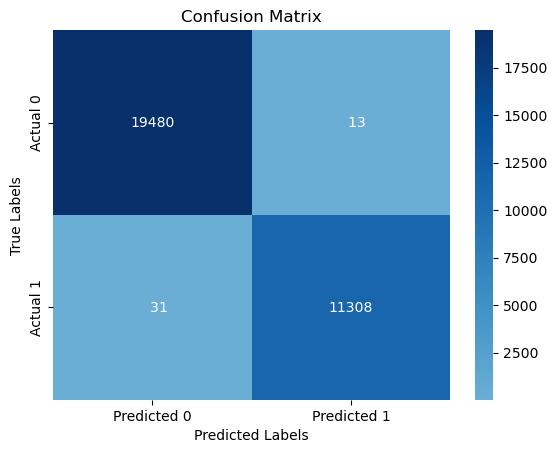

964/964 [==============================] - 25s 26ms/step

Average Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     19493
         1.0       1.00      1.00      1.00     11339

    accuracy                           1.00     30832
   macro avg       1.00      1.00      1.00     30832
weighted avg       1.00      1.00      1.00     30832



In [11]:
all_tp = int(all_tp)
all_fn = int(all_fn)
all_fp = int(all_fp)
all_tn = int(all_tn)

cm = pd.DataFrame(
    data=[[all_tp , all_fp ], [all_fn ,all_tn ]],
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)


sns.heatmap(cm, annot=True,  fmt='5', cmap='Blues', center=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print average classification report
report = classification_report(df['Label'], (model.predict(padded_sequences) > 0.5).astype(int))
print(f'\nAverage Classification Report:\n{report}')


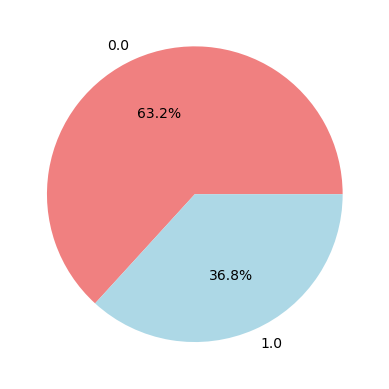

In [12]:
import matplotlib.pyplot as plt
# Pie chart 
label_counts = df['Label'].value_counts()

plt.pie(label_counts.values , labels=label_counts.index, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
plt.show()